# Setup

In [1]:
# !pip install tensorflow-gpu==2.0.0
!apt-get install -y xvfb
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay

/bin/sh: apt-get: command not found
     |████████████████████████████████| 1.5MB 2.7MB/s eta 0:00:01
     |████████████████████████████████| 1.0MB 28.4MB/s eta 0:00:01
  Created wheel for gym: filename=gym-0.10.11-cp36-none-any.whl size=1588338 sha256=ff6e64c7bb6630a59b0d4186372f78fd616274390fa83e22ad0df5ceed81121d
  Stored in directory: /Users/anitahu/Library/Caches/pip/wheels/7b/eb/1f/22c4124f3c64943aa0646daf4612b1c1f00f27d89b81304ebd
Successfully built gym
     |████████████████████████████████| 3.3MB 4.1MB/s eta 0:00:01
  Created wheel for imageio: filename=imageio-2.4.0-cp36-none-any.whl size=3303029 sha256=74b509b4e421ed4f22a66d50f57f64fb2d59a7c1dce744d0a8a29a6fb7e2027a
  Stored in directory: /Users/anitahu/Library/Caches/pip/wheels/31/83/88/a1cba54ac06395d9e4ddcd9cf06911cd0b26cd78af9a61071b
Successfully built imageio
  Found existing installation: imageio 2.5.0
    Uninstalling imageio-2.5.0:
      Successfully uninstalled imageio-2.5.0
     |████████████████████████████████| 1

In [1]:
import base64
import IPython
import PIL.Image
import pyvirtualdisplay

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [1]:
import random
import numpy as np
import gym
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

# DQN 

Paper: https://arxiv.org/pdf/1312.5602.pdf

In [3]:
class DQN:
    def __init__(
            self, 
            env, 
            memory_len=1000,
            time_steps=3,
            gamma=0.85,
            epsilon=1.0,
            epsilon_decay=0.995,
            epsilon_min=0.01,
            learning_rate=0.005,
            tau=0.125
    ):
        self.env     = env
        self.memory  = deque(maxlen=memory_len)
        self.state_shape  = env.observation_space.shape
        self.time_steps = time_steps
        self.stored_states = np.zeros((self.time_steps, self.state_shape[0]))
        
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.tau = tau

        self.model        = self.create_model()
        self.target_model = self.create_model()
        self.rewards = [0]
        self.q_values = []

    def create_model(self):
        model   = Sequential()
        model.add(Dense(32, input_dim=self.state_shape[0]*self.time_steps, activation="relu"))
        model.add(Dense(24, activation="relu"))
        model.add(Dense(self.env.action_space.n))
        model.compile(loss="mean_squared_error",
            optimizer=Adam(lr=self.learning_rate))
        return model
    
    def update_states(self, new_state):
        self.stored_states = np.roll(self.stored_states, -1, axis=0)
        self.stored_states[-1] = new_state

    def act(self, test=False): 
        states = self.stored_states.reshape((1, self.state_shape[0]*self.time_steps))
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        epsilon = 0.01 if test else self.epsilon
        q_values = self.model.predict(states)[0]
        self.q_values.append(max(q_values))
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(q_values)

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size: 
            return

        samples = random.sample(self.memory, batch_size)
        batch_states = []
        batch_target = []
        for sample in samples:
            states, action, reward, new_states, done = sample
            batch_states.append(states.reshape(self.state_shape[0]*self.time_steps))
            states = states.reshape((1, self.state_shape[0]*self.time_steps))
            target = self.target_model.predict(states)[0]
            if done:
                target[action] = reward
            else:
                new_states = new_states.reshape((1, self.state_shape[0]*self.time_steps))
                Q_future = max(self.target_model.predict(new_states)[0])
                target[action] = reward + Q_future * self.gamma
            batch_target.append(target)
        self.model.fit(np.array(batch_states), np.array(batch_target), epochs=1, verbose=0)

    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)

    def save_model(self, fn):
        self.model.save(fn)

    def load_model(self, fn):
        self.model = tf.keras.models.load_model(fn)
        self.target_model = self.model

    def train(self, epoches=10000, max_episodes=10, max_steps=500, resume_episode=0):
        done, episode, steps = True, resume_episode, 0
        while episode < max_episodes:
#         for ep in tqdm(range(epoches)):
            if steps >= max_steps:
                print("Episode {}, reached max step at {} epoches".format(episode, epoches))
                self.save_model("dqn_basic_episode{}.h5".format(episode))
                break
#             if episode >= max_episodes:
#                 break
            if done:
                self.stored_states = np.zeros((self.time_steps, self.state_shape[0]))
                done, cur_state, steps = False, self.env.reset(), 0
                episode += 1
                self.rewards.append(0)
                print("episode {}: {} reward".format(episode, self.rewards[-2]))
                if episode%10 == 0:
                    self.save_model("DNN/dqn_episode{}.h5".format(episode))
            action = self.act()
            new_state, reward, done, _ = self.env.step(action)
            modified_reward = 1 - abs(new_state[2] / (np.pi / 2)) # divide by 90 degrees
            cur_stored_states = self.stored_states
            self.update_states(new_state)
            self.remember(cur_stored_states, action, modified_reward, self.stored_states, done)
            self.replay() # internally iterates default (prediction) model
            self.target_train() # iterates target model

            self.rewards[-1] += reward
            steps += 1

    def test(self, render=True, fps=30, filename='test_render.mp4'):
        cur_state, done, rewards = self.env.reset(), False, 0
        with imageio.get_writer(filename, fps=fps) as video:
            while not done:
                action = self.act(test=True)
                new_state, reward, done, _ = self.env.step(action)
                self.update_states(new_state)
                rewards += reward
                if render:
                    video.append_data(self.env.render(mode='rgb_array'))
        print("Total rewards: ", rewards)

    def plot_q_values(self):
        plt.plot(self.q_values, label="Q value")
        plt.legend(loc="upper right")
        plt.show()

    def plot_rewards(self):
        plt.plot(self.rewards, label="Reward")
        plt.legend(loc="upper right")
        plt.show()

# Training

In [4]:
env = gym.make('Breakout-ram-v0')
dqn_agent = DQN(env, time_steps=1)

DependencyNotInstalled: No module named 'atari_py'. (HINT: you can install Atari dependencies by running 'pip install gym[atari]'.)

In [ ]:
dqn_agent.train(epoches=10000, max_episodes=50)

episode  1
episode  2
episode  3
episode  4
episode  5
episode  6
episode  7
episode  8
episode  9
episode  10
episode  11
episode  12
episode  13
episode  14
episode  15
episode  16
episode  17
episode  18
episode  19
episode  20
episode  21
episode  22
episode  23
episode  24
episode  25
episode  26
episode  27
episode  28
episode  29
episode  30
episode  31
episode  32
episode  33
episode  34
episode  35
episode  36
episode  37


In [16]:
dqn_agent.save_model("DNN/dnn_2_states.h5")

In [21]:
dqn_agent.load_model("DNN/dnn_2_states.h5")

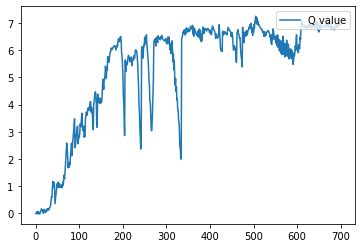

In [13]:
dqn_agent.plot_q_values()

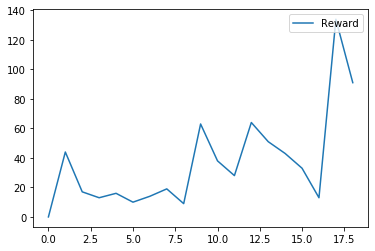

In [14]:
dqn_agent.plot_rewards()

In [28]:
dqn_agent.test(env)

Total rewards:  42.0


In [14]:
embed_mp4('test_render.mp4')